# DSCI 552 Assignment 3

Name: Anushka Deshpande  
USC ID: 5914802345  
Github Username: anushka-deshpande  


## 1. Time Series Classification Part 1: Feature Creation/Extraction

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import zipfile

import os
import csv

from sklearn.utils import resample

warnings.filterwarnings('ignore')

#### (a) Download the AReM data from:   
https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29.   
The dataset contains 7 folders that represent seven types of activities. In each folder, there are multiple files each of which represents an instant of a human performing an activity. 1 Each file containis 6 time series collected from activities of the same person, which are called avg rss12, var rss12, avg rss13, var rss13, vg rss23, and ar rss23. There are 88 instances in the dataset, each of which contains 6 time series and each time series has 480 consecutive values.

In [2]:
COLUMN_NAMES = ["time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
OG_COLUMN_NAMES = ["# Columns: time","avg_rss12","var_rss12","avg_rss13","var_rss13","avg_rss23","var_rss23"]
STATS = ['mean', 'std', 'min', '1st_quartile', 'median', '3rd_quartile', 'max']
ORDERED_STATS = ['min', 'max', 'mean', 'median', 'std', '1st_quartile', '3rd_quartile']
ROOT = './AReM/'
sniffer = csv.Sniffer()

In [3]:
with zipfile.ZipFile('../data/AReM.zip', 'r') as zip_ref:
  zip_ref.extractall()

#### (b) Keep datasets 1 and 2 in folders bending1 and bending2, as well as datasets 1, 2, and 3 in other folders as test data and other datasets as train data.

In [4]:
def test_train_split(root):
  train_dir = []
  test_dir = []

  for root, directory, files in os.walk(root):
    for file in files:
      if 'pdf' not in file:
        fpof = os.path.join(root, file)
        if 'bending1' in fpof or 'bending2' in fpof:
          if 'dataset1.csv' in fpof or 'dataset2.csv' in fpof:
            test_dir.append(fpof)
          else:
            train_dir.append(fpof)
        else:
          if 'dataset1.csv' in fpof or 'dataset2.csv' in fpof or 'dataset3.csv' in fpof:
            test_dir.append(fpof)
          else:
            train_dir.append(fpof)

  return train_dir, test_dir

In [5]:
trainDir, testDir = test_train_split(ROOT)

In [6]:
len(trainDir)

69

In [7]:
len(testDir)

19

#### (c) Feature Extraction

Classification of time series usually needs extracting features from them. In this problem, we focus on time-domain features.


##### (i) Research what types of time-domain features are usually used in time series classification and list them (examples are minimum, maximum, mean, etc)

The types of time-domain features that are usually part of a time-series classification include:
* maximum
* minimum
* mean
* median
* standard deviation
* first quartile
* third quartile
* correlation structure
* distribution
* entropy
* stationarity
* scaling properties


##### (ii) Extract the time-domain features minimum, maximum, mean, median, standard deviation, first quartile, and third quartile for all of the 6 time series in each instance. You are free to normalize/standardize features or use them directly.

In [8]:
def getLabel(file):
  parent_path = os.path.dirname(file)
  fname_components = parent_path.split("/")
  return fname_components[-1]

def getSeparator(file):
  open_file = open(file)
  return sniffer.sniff(open_file.read()).delimiter

def getColumns():
  features = []
  for i in range(1, 7):
    for stat in STATS:
      features.append(f'{stat}{i}')
  return features

def loadData(files, features, columns, segments=1, standard=False):

    instances  = []
    full_dataset = pd.DataFrame()
    labels = []
    for file in files:
        #print("opened file ",file)
        labels.append(getLabel(file))
        separator = getSeparator(file)

        
        if separator == ",":
            df = pd.read_csv(file, skiprows=5, header=None, on_bad_lines='skip')
        else:
            df = pd.read_csv(file, skiprows=5, sep="\\s+", header=None, on_bad_lines='skip')

        df.columns = OG_COLUMN_NAMES

        # breaking time series into equal lengths
        segLength = int(df.shape[0] / segments)
        description = []
        for i in range(segments):
            start1 = i * segLength
            end1 = min((i + 1) * segLength, df.shape[0])
            currentSegment = df[start1 : end1]
            timeColumn = "# Columns: time"
            currentDescribe = currentSegment.describe().drop('count').drop(columns=timeColumn).T
            description.append(currentDescribe.values.flatten())

        #print(df.shape)

        full_dataset = pd.concat([full_dataset, df])
        instances.append(np.concatenate(description))

    # reordering
    feature_df = pd.DataFrame(instances)
    feature_df.columns = getColumns()
    feature_df = feature_df.loc[:, features]

    # label addition
    feature_df['label'] = pd.Series(labels)

    return feature_df, full_dataset

In [9]:
def getOrderedColumns():
  features = []
  for i in range(1,7):
    for stat in ORDERED_STATS:
      features.append(f'{stat}{i}')
  return features

In [10]:
features = getOrderedColumns()
train_stats, train_dataset = loadData(trainDir, features, OG_COLUMN_NAMES)
test_stats, test_dataset = loadData(testDir, features, OG_COLUMN_NAMES)

In [11]:
train_dataset.shape

(33117, 7)

In [12]:
test_dataset.shape

(9120, 7)

In [13]:
train_stats.shape

(69, 43)

In [14]:
test_stats.shape

(19, 43)

##### (iii) Estimate the standard deviation of each of the time-domain features you extracted from the data. Then, use Python’s bootstrapped or any other method to build a 90% bootsrap confidence interval for the standard deviation of each feature.

In [15]:
full_stats = train_stats
full_stats.describe().loc['std']

min1             8.794295
max1             4.429182
mean1            4.917692
median1          4.956111
std1             1.758670
1st_quartile1    5.731647
3rd_quartile1    4.783645
min2             0.000000
max2             5.147841
mean2            1.600701
median2          1.436960
std2             0.902808
1st_quartile2    0.952201
3rd_quartile2    2.158416
min3             3.053869
max3             4.759853
mean3            3.863097
median3          3.845730
std3             0.995959
1st_quartile3    4.145255
3rd_quartile3    3.946023
min4             0.000000
max4             2.302408
mean4            1.179861
median4          1.150092
std4             0.473576
1st_quartile4    0.842501
3rd_quartile4    1.566564
min5             5.368786
max5             5.449726
mean5            5.120426
median5          5.267414
std5             1.057998
1st_quartile5    5.543882
3rd_quartile5    4.957231
min6             0.051766
max6             2.540166
mean6            1.171401
median6     

In [16]:
bootstrap_df = pd.DataFrame(columns=["feature", "interval"])
dfIdx=0
for colName in train_stats.columns[:-1]:
    allStds = []
    feature = full_stats[colName].to_numpy()
    for _ in range(1000):
        resamples = resample(feature, replace=True, n_samples=feature.shape[0])
        allStds.append(np.std(resamples))
    bootstrap_df.loc[dfIdx]=[colName,str(np.percentile(allStds,5))[:4]+" , "+str(np.percentile(allStds,95))[:4]]
    dfIdx+=1
bootstrap_df

,feature,interval
0,min1,"7.41 , 10.0"
1,max1,"3.22 , 5.33"
2,mean1,"4.31 , 5.38"
3,median1,"4.27 , 5.42"
4,std1,"1.52 , 1.93"
5,1st_quartile1,"5.10 , 6.11"
6,3rd_quartile1,"3.96 , 5.48"
7,min2,"0.0 , 0.0"
8,max2,"4.65 , 5.46"
9,mean2,"1.40 , 1.72"


##### (iv) Use your judgement to select the three most important time-domain features (one option may be min, mean, and max).
Since the following question asks us to label 1 for bending class and 0 for other classes, we use the same to determine the top 3 features.

In [17]:
train_data_bending = pd.DataFrame(train_stats)
train_data_bending['label']=train_data_bending['label'].replace('bending1',1)
train_data_bending['label']=train_data_bending['label'].replace('bending2',1)
train_data_bending.loc[train_data_bending['label'] != 1, 'label'] = 0
train_data_bending

,min1,max1,mean1,median1,std1,1st_quartile1,3rd_quartile1,min2,max2,mean2,...,1st_quartile5,3rd_quartile5,min6,max6,mean6,median6,std6,1st_quartile6,3rd_quartile6,label
0,36.25,48.00,43.969125,44.50,1.618364,43.310,44.67,0.0,1.50,0.413125,...,20.5000,23.7500,0.0,2.96,0.555312,0.490,0.487826,0.0000,0.830,1
1,37.00,48.00,43.454958,43.25,1.386098,42.500,45.00,0.0,1.58,0.378083,...,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.870,1
2,33.00,47.75,42.179812,43.50,3.670666,39.150,45.00,0.0,3.00,0.696042,...,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.000,1
3,33.00,45.75,41.678063,41.75,2.243490,41.330,42.75,0.0,2.83,0.535979,...,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.500,1
4,35.00,47.40,43.954500,44.33,1.558835,43.000,45.00,0.0,1.70,0.426250,...,35.3625,36.5000,0.0,1.79,0.493292,0.430,0.513506,0.0000,0.940,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,18.50,44.25,35.752354,36.00,4.614802,33.000,39.33,0.0,12.60,3.328104,...,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.060,0
65,24.25,45.00,37.177042,36.25,3.581301,34.500,40.25,0.0,8.58,2.374208,...,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.900,0
66,23.33,43.50,36.248768,36.75,3.824632,33.415,39.25,0.0,9.71,2.737307,...,15.7500,21.0000,0.0,11.15,3.532463,3.110,1.965267,2.1700,4.625,0
67,26.25,44.25,36.957458,36.29,3.434863,34.500,40.25,0.0,8.64,2.420083,...,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.030,0


plotting a pairplot for all features, bending vs other activities

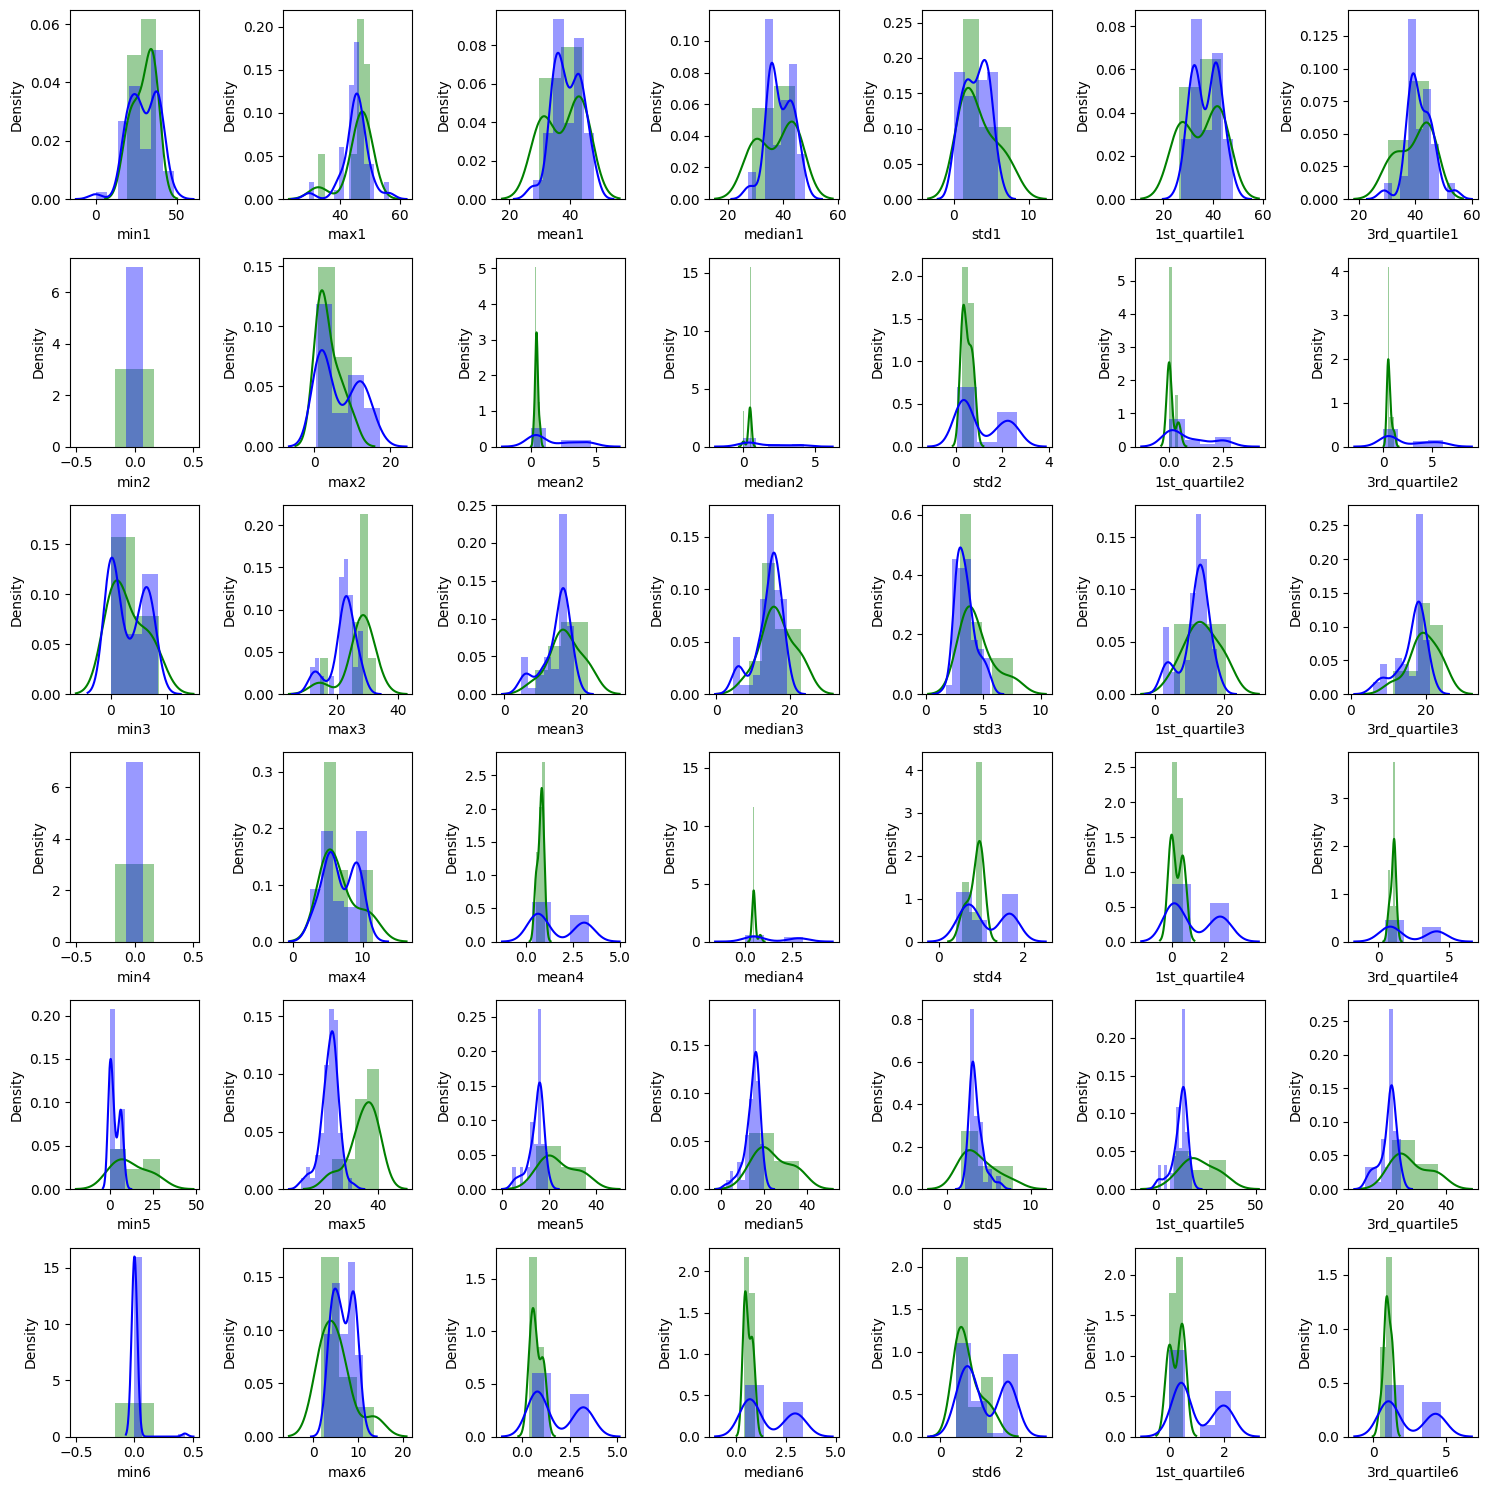

In [18]:
fig, axis = plt.subplots(6,7, figsize=(15,15))

for i in range(6):
  for j, feature in enumerate(ORDERED_STATS):
    sns.distplot(train_data_bending.loc[train_data_bending['label']==1][feature +str(i+1)],
                 hist = True,
                 kde = True,
                 ax = axis[i,j],
                 label = 'Bend',
                 color = "green")

    sns.distplot(train_data_bending.loc[train_data_bending['label']==0][feature +str(i+1)],
                 hist = True,
                 kde = True,
                 ax = axis[i,j],
                 label = 'No Bend',
                 color = "blue")

plt.tight_layout()
plt.show()

Since this is a regression problem, the choice of important time-domain features will be majorly driven by the feasibility of demarkation and there should be relatively clear separated distribution and hence the choice would be

- **mean**
- **max**
- **3rd quartile**
  

## 2. ISLR 3.7.4

I collect a set of data (n = 100 observations) containing a single predictor and a quantitative response. I then fit a linear regression model to the data, as well as a separate cubic regression, i.e. Y = β0 +β1X +β2X2 +β3X3 +ε.

(a) Suppose that the true relationship between X and Y is linear, i.e. Y = β0 + β1X + ε. Consider the training residual sum of squares (RSS) for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

**Ans. We know that the true relationship between X and Y is linear. So, it is expected that the training RSS for the cubic regression is  lower than the training RSS for the linear regression.**

(b) Answer (a) using test rather than training RSS.

**Ans: The cubic regression is wtih higher order terms and more predictors, therefore it will have a problem of overfitting. So, for test RSS, linear regression will have a lower RSS.**

(c) Suppose that the true relationship between X and Y is not linear, but we don’t know how far it is from linear. Consider the training RSS for the linear regression, and also the training RSS for the cubic regression. Would we expect one to be lower than the other, would we expect them to be the same, or is there not enough information to tell? Justify your answer.

**Ans. Although we dont know about the true relationship between X and Y, the cubic regression has more flexibility, so it will have a lower RSS than linear regression.**

(d) Answer (c) using test rather than training RSS.

**Ans. Here, it will depend on how close the true relation is to either of the regressions. The information provided is not enough to know the answer.** 

## References:

1. AReM Dataset: https://archive.ics.uci.edu/ml/datasets/Activity+Recognition+system+based+on+Multisensor+data+fusion+\%28AReM\%29.    
2. Adding files using os.walk: https://stackoverflow.com/questions/42405770/limit-no-of-filepaths-using-os-walk-where-huge-files-in-a-directory
3. Time Series Classification: https://stats.stackexchange.com/questions/50807/features-for-time-series-classification
4. Time Series Classification: https://www.analyticsvidhya.com/blog/2019/01/introduction-time-series-classification/
5. Feature Extraction: https://medium.com/@dreamferus/time-series-feature-extraction-using-pandas-44af6fb5fce9